# Time-series prediction - Forecast multi-horizon

Ejemplo de predicción de series temporales.

**Serie de tiempo:** serie de datos puntuales en un orden de tiempo dado (datos discretos).

La predicción de series temporales es el proceso de predecir valores futuros en función del pasado. Por ej. predecir el precio de una acción en función de precios pasados.

<img src="images/timeseries.png" alt="drawing" width="500"/>

#### Forecast horizon (horizonte de pronóstico)

El horizonte del pronóstico es el período de tiempo para el cual se debe preparar la predicción. Esto puede variar en pronósticos a corto (una semana o un mes), mediano (1 a 3 meses) o largo plazo (mas de 3 meses).

<img src="images/forecast_horizon.png" alt="drawing" width="560"/>

<img src="images/forecast_horizon_x.png" alt="drawing" width="400"/>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# Fuente: https://finance.yahoo.com/
df = pd.read_csv('datasets/merval.csv')

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-01-03,639.599976,652.549988,639.599976,651.830017,651.830017,0.0
1,1997-01-06,651.830017,662.030029,651.830017,656.979980,656.979980,0.0
2,1997-01-07,656.979980,663.489990,656.979980,663.489990,663.489990,0.0
3,1997-01-08,664.020020,671.599976,663.719971,664.580017,664.580017,0.0
4,1997-01-09,664.469971,672.169983,664.469971,672.169983,672.169983,0.0


In [4]:
df = df[~df.Close.isna()].reset_index(drop=True)
#df = df.head(20)

In [5]:
df.shape

(2716, 7)

In [6]:
df.Date.min()

'1997-01-03'

In [7]:
df.Date.max()

'2007-12-28'

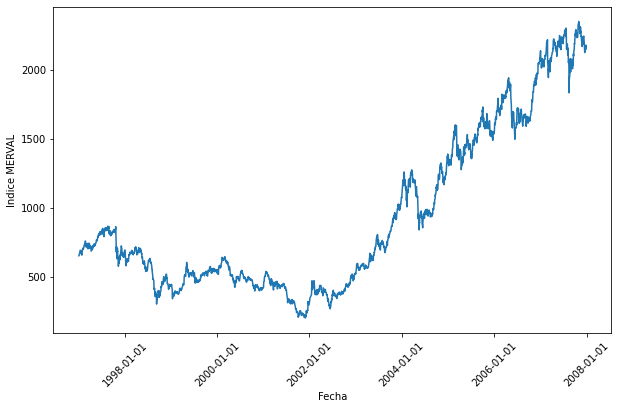

In [8]:
import matplotlib.dates as mdates
import datetime

fmt = mdates.DateFormatter('%Y-%m-%d')
x_date = [datetime.datetime.strptime(i, '%Y-%m-%d') for i in df.Date]

fig, ax = plt.subplots(figsize=(10, 6))


plt.plot(x_date, df.Close)
plt.xticks(rotation=45)
ax.xaxis.set_major_formatter(fmt)

plt.xlabel('Fecha')
plt.ylabel('Indice MERVAL');


### Split dataset

In [9]:
import torch
import torch.nn as nn
import numpy as np

In [10]:
from sklearn.preprocessing import MinMaxScaler

# data leakeage

price = df[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))

/var/folders/36/xhls1xbs1676nkndj0s_rtnr0000gn/T/ipykernel_7938/829518123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price.loc[:, 'Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


In [11]:
# price = df[['Close']]

In [14]:
#price = df[['Close']]

def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    
    # se crean todas las posibles secuencias de la longitud de la secuencia
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    print("data",data)
    x_train = data[:train_set_size,:-1,:]
    
    print("x", x_train)
    y_train = data[:train_set_size,-1,:]
    print("y", y_train)
    
    return [x_train, y_train]

lookback = 5 # longitud de secuencia
x_train, y_train = split_data(price, lookback)


data [[[-0.58060614]
  [-0.57581676]
  [-0.56976257]
  [-0.56874887]
  [-0.56169034]]

 [[-0.57581676]
  [-0.56976257]
  [-0.56874887]
  [-0.56169034]
  [-0.56284351]]

 [[-0.56976257]
  [-0.56874887]
  [-0.56169034]
  [-0.56284351]
  [-0.55963506]]

 ...

 [[ 0.79147022]
  [ 0.79003801]
  [ 0.79417661]
  [ 0.80365307]
  [ 0.80824713]]

 [[ 0.79003801]
  [ 0.79417661]
  [ 0.80365307]
  [ 0.80824713]
  [ 0.8404709 ]]

 [[ 0.79417661]
  [ 0.80365307]
  [ 0.80824713]
  [ 0.8404709 ]
  [ 0.82961809]]]
x [[[-0.58060614]
  [-0.57581676]
  [-0.56976257]
  [-0.56874887]]

 [[-0.57581676]
  [-0.56976257]
  [-0.56874887]
  [-0.56169034]]

 [[-0.56976257]
  [-0.56874887]
  [-0.56169034]
  [-0.56284351]]

 ...

 [[ 0.34205656]
  [ 0.30541537]
  [ 0.28823853]
  [ 0.3046248 ]]

 [[ 0.30541537]
  [ 0.28823853]
  [ 0.3046248 ]
  [ 0.3138968 ]]

 [[ 0.28823853]
  [ 0.3046248 ]
  [ 0.3138968 ]
  [ 0.29184686]]]
y [[-0.56169034]
 [-0.56284351]
 [-0.55963506]
 ...
 [ 0.3138968 ]
 [ 0.29184686]
 [ 0.302653

In [46]:
x_train

array([[[-0.58060614],
        [-0.57581676],
        [-0.56976257],
        [-0.56874887]],

       [[-0.57581676],
        [-0.56976257],
        [-0.56874887],
        [-0.56169034]],

       [[-0.56976257],
        [-0.56874887],
        [-0.56169034],
        [-0.56284351]],

       ...,

       [[ 0.34205656],
        [ 0.30541537],
        [ 0.28823853],
        [ 0.3046248 ]],

       [[ 0.30541537],
        [ 0.28823853],
        [ 0.3046248 ],
        [ 0.3138968 ]],

       [[ 0.28823853],
        [ 0.3046248 ],
        [ 0.3138968 ],
        [ 0.29184686]]])

In [20]:
data = np.array(price).flatten()

In [21]:
win_dim = 4
win_max = math.floor(data.shape[0] / win_dim) - 1
datas = []
for i in range(1, win_max+1):
    print(i)
    print("Inicio;", win_dim * i)
    print("Fin;", win_dim * (i + 1))
    print(data[win_dim*i : win_dim * (i + 1)])
    datas.append(data[win_dim*i : win_dim * (i + 1)])
    print("-----")
y_datas = np.vstack(datas)

1
Inicio; 4
Fin; 8
[-0.56169034 -0.56284351 -0.55963506 -0.54660601]
-----
2
Inicio; 8
Fin; 12
[-0.5434999  -0.5487915  -0.5534972  -0.54830789]
-----
3
Inicio; 12
Fin; 16
[-0.5482614  -0.55490148 -0.55692884 -0.57119473]
-----
4
Inicio; 16
Fin; 20
[-0.57625383 -0.56714933 -0.5573008  -0.54584341]
-----
5
Inicio; 20
Fin; 24
[-0.54277449 -0.53005234 -0.52882476 -0.53651573]
-----
6
Inicio; 24
Fin; 28
[-0.53757592 -0.5330283  -0.52915029 -0.52835046]
-----
7
Inicio; 28
Fin; 32
[-0.51867869 -0.51305231 -0.51210371 -0.50401286]
-----
8
Inicio; 32
Fin; 36
[-0.50621691 -0.5081699  -0.51092261 -0.49780989]
-----
9
Inicio; 36
Fin; 40
[-0.48078193 -0.48682681 -0.49641492 -0.51331267]
-----
10
Inicio; 40
Fin; 44
[-0.51939473 -0.52050141 -0.51627932 -0.51600033]
-----
11
Inicio; 44
Fin; 48
[-0.51737669 -0.5075747  -0.4967497  -0.5109133 ]
-----
12
Inicio; 48
Fin; 52
[-0.51909719 -0.52764367 -0.52492814 -0.53353047]
-----
13
Inicio; 52
Fin; 56
[-0.52979198 -0.52757862 -0.51392644 -0.50752821]
----

In [29]:
y_datas.shape

(678, 4)

In [30]:
y_train = y_datas

In [31]:
x_train.shape

(2169, 4, 1)

In [32]:
y_train.shape

(678, 4)

In [36]:
x_train = x_train[:len(y_train), :, :]

In [37]:
x_train

array([[[-0.58060614],
        [-0.57581676],
        [-0.56976257],
        [-0.56874887]],

       [[-0.57581676],
        [-0.56976257],
        [-0.56874887],
        [-0.56169034]],

       [[-0.56976257],
        [-0.56874887],
        [-0.56169034],
        [-0.56284351]],

       ...,

       [[-0.71268215],
        [-0.71515591],
        [-0.71572318],
        [-0.69717938]],

       [[-0.71515591],
        [-0.71572318],
        [-0.69717938],
        [-0.6954868 ]],

       [[-0.71572318],
        [-0.69717938],
        [-0.6954868 ],
        [-0.69344083]]])

In [38]:
y_train

array([[-0.56169034, -0.56284351, -0.55963506, -0.54660601],
       [-0.5434999 , -0.5487915 , -0.5534972 , -0.54830789],
       [-0.5482614 , -0.55490148, -0.55692884, -0.57119473],
       ...,
       [ 0.88746291,  0.88345486,  0.85589007,  0.8447396 ],
       [ 0.79147022,  0.79003801,  0.79417661,  0.80365307],
       [ 0.80824713,  0.8404709 ,  0.82961809,  0.81427339]])

In [28]:
x_train

tensor([[526.4800],
        [528.3000],
        [530.5000],
        [534.4000]])

In [47]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
#x_test = torch.from_numpy(x_test).type(torch.Tensor)

y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
#y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

### RNN

#### Parametros

* input_size: cantidad de datos en la secuencia de entrada
* hidden_dim: numero de features en el estado oculto
* layer_dim: cantidad de capas recurrentes. Si es 2, con el 2do rnn tomamos la salida del 1er rnn y se calcila el resultado final 
* batch_first: utilizará la primera dimensión como dimensión de secuencia (True)
* dropout: introduce dropout excepto en la ultima capa
* bidirectional: si el contexto tiene importancia (hacia adelante y atrás, en términos temporales)

In [48]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # definicion del numero de capas y nos por cada una
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # capas rnn
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # capa fc
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0):
        # inicializacion del estado oculto con zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Propagación hacia adelante pasando la entrada y el estado oculto al modelo
        out, h0 = self.rnn(x, h0.detach()) # detach devuelve un nuevo tensor que no requiere gradiente

        # reshape de output para conectar al fc
        out = out[:, -1, :]

        # convertir el estado final a la forma de salida deseada (batch_size, output_dim)
        out = self.fc(out)
        return out, h0

In [49]:
input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 4
num_epochs = 50

model = RNNModel(input_dim, hidden_dim, num_layers, output_dim, 0)
print(model)

criterion = torch.nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

RNNModel(
  (rnn): RNN(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
)


In [50]:
import time
hist = np.zeros(num_epochs)
hidden = None
start_time = time.time()
lstm = []

h0 = torch.zeros(num_layers, 5, hidden_dim).requires_grad_()

for t in range(num_epochs):
    y_train_pred, h0 = model(x_train, h0)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

/Users/alejandrodebus/my_envs/dlc/lib/python3.9/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([2169, 1])) that is different to the input size (torch.Size([2169, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  0 MSE:  0.3206307291984558
Epoch  1 MSE:  0.21161822974681854
Epoch  2 MSE:  0.18142053484916687
Epoch  3 MSE:  0.12491843849420547
Epoch  4 MSE:  0.0987132117152214
Epoch  5 MSE:  0.07038518041372299
Epoch  6 MSE:  0.045511625707149506
Epoch  7 MSE:  0.038104936480522156
Epoch  8 MSE:  0.023393630981445312
Epoch  9 MSE:  0.013336148113012314
Epoch  10 MSE:  0.03326478227972984
Epoch  11 MSE:  0.027950340881943703
Epoch  12 MSE:  0.02077767439186573
Epoch  13 MSE:  0.011041592806577682
Epoch  14 MSE:  0.009255976416170597
Epoch  15 MSE:  0.015615363605320454
Epoch  16 MSE:  0.021846439689397812
Epoch  17 MSE:  0.019981026649475098
Epoch  18 MSE:  0.012446034699678421
Epoch  19 MSE:  0.005734793841838837
Epoch  20 MSE:  0.003673899220302701
Epoch  21 MSE:  0.005597149487584829
Epoch  22 MSE:  0.009849043563008308
Epoch  23 MSE:  0.010448416694998741
Epoch  24 MSE:  0.006078273057937622
Epoch  25 MSE:  0.00230966042727232
Epoch  26 MSE:  0.0019595897756516933
Epoch  27 MSE:  0.004

In [51]:


predict = pd.DataFrame(scaler.inverse_transform(y_train_pred[0:2].detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm[0:2].detach().numpy()))

In [52]:
original

,0
0,672.169983
1,670.929993


In [57]:
original

,0
0,672.169983
1,670.929993
2,674.380005
3,688.390015
4,691.729980
...,...
2164,1586.089966
2165,1603.709839
2166,1613.680054
2167,1589.969971


In [56]:
predict

,0,1,2,3
0,645.431580,650.962646,666.826538,624.696106
1,650.061096,655.271545,671.771362,630.096558
2,653.822937,659.075806,675.042908,632.968262
3,655.892212,661.120117,677.479980,635.972534
4,662.098328,666.670105,683.960999,642.607727
...,...,...,...,...
2164,1673.838379,1678.162598,1701.768433,1695.137085
2165,1667.282959,1663.509521,1692.721191,1682.639526
2166,1656.947021,1651.364258,1682.740967,1672.804688
2167,1649.360596,1649.544067,1676.716919,1669.124756


In [54]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

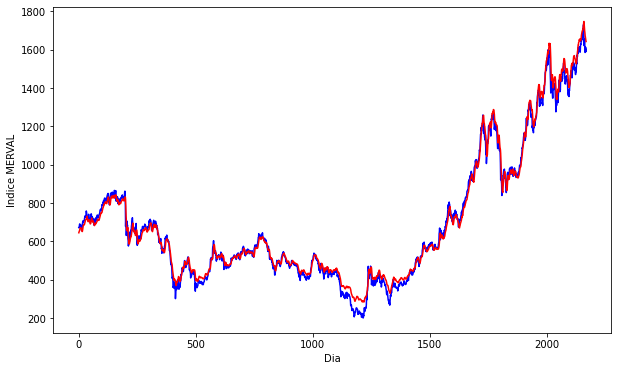

In [55]:
fig, ax = plt.subplots(figsize=(10, 6))

plt.plot(original, c='b')
plt.plot(predict.iloc[:, 0], c='r')
plt.xlabel('Dia')
plt.ylabel('Indice MERVAL');